# Setup env

In [51]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  



import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif



import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing



np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-ekedqtv_
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-ekedqtv_
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [52]:
!pip freeze > requirements.txt

In [53]:
LABEL_CLASSES = {
    0: 'NO tumor',
    1: 'DEAD/CORE tissue',  # 또는 NON-ENHANCING tumor CORE
    2: 'SWELLING',
    3: 'ENHANCED'  # 기존의 클래스 4가 3으로 통합됨
}

NUM_SLICES = 100  
START_SLICE = 22  # 포함할 볼륨의 첫 번째 슬라이스

In [54]:
TRAIN_DATASET_PATH = '../brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [55]:
# 이미지 크기 설정
IMAGE_SIZE = 128

In [56]:
# Dice Loss 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    num_classes = 4
    for idx in range(num_classes):
        true_flat = K.flatten(y_true[:, :, :, idx])
        pred_flat = K.flatten(y_pred[:, :, :, idx])
        intersection = K.sum(true_flat * pred_flat)
        score = ((2. * intersection + smooth) / (K.sum(true_flat) + K.sum(pred_flat) + smooth))
        if idx == 0:
            cumulative_score = score
        else:
            cumulative_score += score
    average_score = cumulative_score / num_classes
    return average_score


# Per-class Dice Coefficient Functions
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 1])) + K.sum(K.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 2])) + K.sum(K.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:, :, :, 3])) + K.sum(K.square(y_pred[:, :, :, 3])) + epsilon)


# Precision Calculation
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_val = true_positives / (predicted_positives + K.epsilon())
    return precision_val

    
# Sensitivity Calculation     
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Specificity Calculation
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [57]:


# U-Net 모델 빌드 함수
def create_unet(inputs, kernel_initializer, dropout_rate):
    # Down-sampling
    x1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    x1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x1)
    
    p1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(p1)
    x2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x2)
    
    p2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(p2)
    x3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x3)
    
    p3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(p3)
    x4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x4)
    
    # Bottom layer
    p4 = MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(p4)
    x5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x5)
    x5 = Dropout(dropout_rate)(x5)

    # Up-sampling
    u6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(UpSampling2D(size=(2,2))(x5))
    m6 = concatenate([x4, u6], axis=3)
    x6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(m6)
    x6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x6)

    u7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(UpSampling2D(size=(2,2))(x6))
    m7 = concatenate([x3, u7], axis=3)
    x7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(m7)
    x7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x7)

    u8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(UpSampling2D(size=(2,2))(x7))
    m8 = concatenate([x2, u8], axis=3)
    x8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(m8)
    x8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x8)
    
    u9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=kernel_initializer)(UpSampling2D(size=(2,2))(x8))
    m9 = concatenate([x1, u9], axis=3)
    x9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(m9)
    x9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=kernel_initializer)(x9)
    
    output_layer = Conv2D(4, (1,1), activation='softmax')(x9)
    
    return Model(inputs=inputs, outputs=output_layer)

input_tensor = Input((IMAGE_SIZE, IMAGE_SIZE, 2))

model = create_unet(input_tensor, 'he_normal', 0.2)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

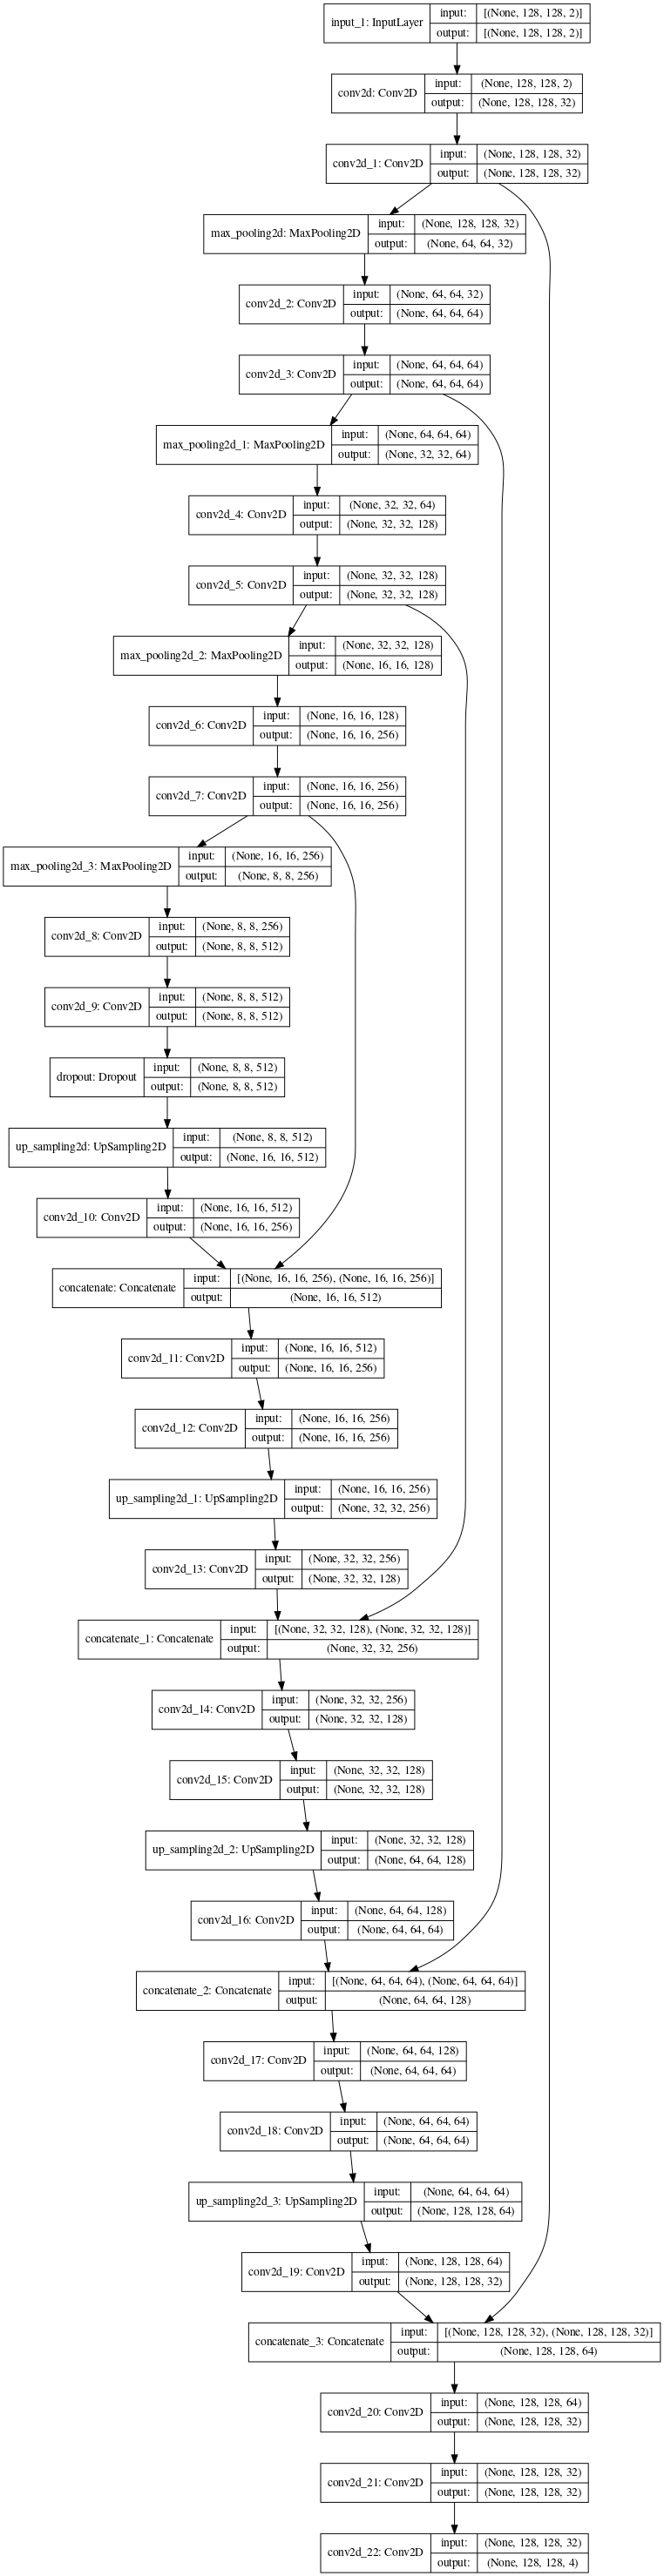

In [58]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=70
)

# Load data
Loading all data into memory is not a good idea since the data are too big to fit in.
So we will create dataGenerators - load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [59]:
# 학습 및 검증 데이터셋 디렉토리 목록
train_val_dirs = [entry.path for entry in os.scandir(TRAIN_DATASET_PATH) if entry.is_dir()]

# 형식 오류가 있는 파일 제거
train_val_dirs.remove(TRAIN_DATASET_PATH + 'BraTS20_Training_355')

# 디렉토리 경로에서 ID 추출 함수
def extract_ids_from_paths(directory_list):
    ids = []
    for directory in directory_list:
        ids.append(directory[directory.rfind('/') + 1:])
    return ids

train_and_test_ids = extract_ids_from_paths(train_val_dirs)

# 데이터셋 분할
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)


**Override Keras sequence DataGenerator class**

In [60]:


class DataGenerator(keras.utils.Sequence):
    'Keras에 맞는 데이터 생성기'
    
    def __init__(self, id_list, dimensions=(IMAGE_SIZE, IMAGE_SIZE), batch_size=1, channels=2, shuffle=True):
        '초기화'
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.id_list = id_list
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '에포크당 배치 수'
        return int(np.floor(len(self.id_list) / self.batch_size))

    def __getitem__(self, index):
        '한 배치의 데이터 생성'
        # 배치 인덱스 생성
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # 배치 ID 리스트 생성
        batch_ids = [self.id_list[k] for k in batch_indices]

        # 데이터 생성
        X, y = self._generate_data(batch_ids)

        return X, y

    def on_epoch_end(self):
        '에포크마다 인덱스 업데이트'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _generate_data(self, batch_ids):
        '배치 크기만큼의 샘플 데이터 생성' # X : (n_samples, *dim, n_channels)
        # 초기화
        X = np.zeros((self.batch_size * NUM_SLICES, *self.dimensions, self.channels))
        y = np.zeros((self.batch_size * NUM_SLICES, 240, 240))
        
        # 데이터 생성
        for batch_index, id in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, id)

            flair_path = os.path.join(case_path, f'{id}_flair.nii')
            flair = nib.load(flair_path).get_fdata()    

            ce_path = os.path.join(case_path, f'{id}_t1ce.nii')
            ce = nib.load(ce_path).get_fdata()
            
            seg_path = os.path.join(case_path, f'{id}_seg.nii')
            seg = nib.load(seg_path).get_fdata()
        
            for slice_index in range(NUM_SLICES):
                X[slice_index + NUM_SLICES * batch_index, :, :, 0] = cv2.resize(flair[:, :, slice_index + START_SLICE], self.dimensions)
                X[slice_index + NUM_SLICES * batch_index, :, :, 1] = cv2.resize(ce[:, :, slice_index + START_SLICE], self.dimensions)
                
                y[slice_index + NUM_SLICES * batch_index] = seg[:, :, slice_index + START_SLICE]
                    
        # 마스크 생성
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, self.dimensions)
        return X / np.max(X), Y

# 데이터 생성기 인스턴스화
train_generator = DataGenerator(train_ids)
validation_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


**Add callback for training process**

In [61]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
    ),
    csv_logger
]


# Train model
My best model was trained with 81% accuracy on mean IOU and 65.5% on Dice loss <br>
I will load this pretrained model instead of training again

In [62]:
K.clear_session()
# train by 50 epochs
history =  model.fit(train_generator,
                    epochs=50,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = validation_generator
                     )  
model.save("3D_MRI_Brain_tumor_segmentation.h5")

249/249 [==============================] - 124s 487ms/step - loss: 0.2131 - accuracy: 0.9757 - mean_io_u: 0.5576 - dice_coef: 0.2544 - precision: 0.9469 - sensitivity: 0.9296 - specificity: 0.9948 - dice_coef_necrotic: 0.0428 - dice_coef_edema: 0.0964 - dice_coef_enhancing: 0.0349 - val_loss: 0.0732 - val_accuracy: 0.9813 - val_mean_io_u: 0.5886 - val_dice_coef: 0.2794 - val_precision: 0.9822 - val_sensitivity: 0.9810 - val_specificity: 0.9941 - val_dice_coef_necrotic: 0.0951 - val_dice_coef_edema: 0.1335 - val_dice_coef_enhancing: 0.0587


In [66]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import cv2

# 모델 로드
model = tf.keras.models.load_model("3D_MRI_Brain_tumor_segmentation.h5", custom_objects={
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
})

def augment_image(image):
    # 이미지 회전 (0도에서 90도 사이)
    angle = np.random.uniform(0, 90)
    center = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    image_rotated = cv2.warpAffine(image, rotation_matrix, (IMAGE_SIZE, IMAGE_SIZE))

    # 이미지 확대 (1.0배에서 1.1배 사이)
    scale_factor = np.random.uniform(1.0, 1.1)
    image_scaled = cv2.resize(image_rotated, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

    # 크기 초과 시 원래 이미지 크기로 자르기
    if image_scaled.shape[0] > IMAGE_SIZE or image_scaled.shape[1] > IMAGE_SIZE:
        start_x = (image_scaled.shape[1] - IMAGE_SIZE) // 2
        start_y = (image_scaled.shape[0] - IMAGE_SIZE) // 2
        image_scaled = image_scaled[start_y:start_y + IMAGE_SIZE, start_x:start_x + IMAGE_SIZE]
    
    return image_scaled

def preprocess_image(image_file, slice_idx=None):
    # NIfTI 파일 로드
    img_data = nib.load(image_file).get_fdata()
    
    # 필요한 경우 특정 슬라이스 선택
    if slice_idx is not None:
        img_data = img_data[:, :, slice_idx]
    
    # 이미지 크기 조정
    img_resized = cv2.resize(img_data, (IMAGE_SIZE, IMAGE_SIZE))
    
    # 정규화
    img_normalized = img_resized / np.max(img_resized)
    
    # 데이터 증강 적용
    img_augmented = augment_image(img_normalized)
    
    return img_augmented

def predict(images, slice_idx):
    X = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 2))
    
    # 각 이미지의 특정 슬라이스 전처리
    X[0, :, :, 0] = preprocess_image(images[0], slice_idx)
    X[0, :, :, 1] = preprocess_image(images[1], slice_idx)
    
    # 예측
    pred = model.predict(X)
    
    return np.argmax(pred[0], axis=-1)

# 예제 사용법
image_files = [
    '/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_flair.nii',
    '/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1ce.nii'
]

slice_idx = 75  # 예제 슬라이스 인덱스
prediction_result = predict(image_files, slice_idx)


In [67]:
import numpy as np

def classify_pixels(prediction_result):
    # 각 픽셀에 대해 가장 높은 확률의 클래스를 선택
    classified_pixels = np.argmax(prediction_result, axis=-1)
    return classified_pixels

In [70]:
classify_pixels(prediction_result)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Prediction examples 

# Evaluation

In [71]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_score, calc_precision, calc_sensitivity, calc_specificity, dice_score_necrotic, dice_score_edema, dice_score_enhancing] )
# Evaluate the model on test data
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 14s 284ms/step - loss: 0.0658 - accuracy: 0.9832 - mean_io_u: 0.5850 - dice_score: 0.2765 - calc_precision: 0.9835 - calc_sensitivity: 0.9831 - calc_specificity: 0.9945 - dice_score_necrotic: 0.0723 - dice_score_edema: 0.1140 - dice_score_enhancing: 0.0562
test loss, test acc: [0.06473418325185776, 0.9835851788520813, 0.5847488045692444, 0.2753102481365204, 0.9838435053825378, 0.9834956526756287, 0.9946266412734985, 0.0700608640909195, 0.10891618579626083, 0.0571863017976284]
